In [0]:
!mkdir -p model
# !pip install scikit-plot > /dev/null
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [0]:
!pip install -q scikit-plot

In [0]:
import numpy as np
import os,time
import cv2
import keras
from keras import backend as K
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow.keras.utils import plot_model

In [0]:
from numba import cuda

In [0]:
batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 15
result = pd.DataFrame()

In [0]:
def get_dataset(dataset_name,final_shape=(32,32),classes=10):
    if dataset_name == "mnist":
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, shuffle=True ,random_state=42)
        
        pad_0 = int((final_shape[0]-28)/2)
        pad_1 = int((final_shape[1]-28)/2)
        
        x_train = x_train.astype('float32')        
        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
        x_train = np.pad(x_train, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_train = np.stack((x_train,)*3, axis=-1)
        x_train = x_train[:,:,:,0,:]
        
        x_test = x_test.astype('float32')
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
        x_test = np.pad(x_test, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_test = np.stack((x_test,)*3, axis=-1)
        x_test = x_test[:,:,:,0,:]
        
        x_val = x_val.astype('float32')
        x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
        x_val = np.pad(x_val, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        x_val = np.stack((x_val,)*3, axis=-1)
        x_val = x_val[:,:,:,0,:]
        
        y_train = keras.utils.to_categorical(y_train, classes)
        y_test = keras.utils.to_categorical(y_test, classes)
        y_val = keras.utils.to_categorical(y_val, classes)
        
    if dataset_name == "cifar10":
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, shuffle=True ,random_state=42)

        pad_0 = int((final_shape[0]-32)/2)
        pad_1 = int((final_shape[1]-32)/2)
        
        x_train = x_train.astype('float32')        
        x_train = np.pad(x_train, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        x_val = x_val.astype('float32')
        x_val = np.pad(x_val, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        x_test = x_test.astype('float32')
        x_test = np.pad(x_test, ((0,0),(pad_0,pad_1),(pad_0,pad_1),(0,0)), 'constant')
        
        y_train = keras.utils.to_categorical(y_train, classes)
        y_test = keras.utils.to_categorical(y_test, classes)
        y_val = keras.utils.to_categorical(y_val, classes)
        
    return x_train, x_test, x_val, y_train, y_test, y_val

(x_train, x_test, x_val, y_train, y_test, y_val) = get_dataset("mnist",final_shape=(32,32),classes=10)
print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape,y_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(40200, 32, 32, 3) (40200, 10)
(19800, 32, 32, 3) (19800, 10)
(10000, 32, 32, 3) (10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


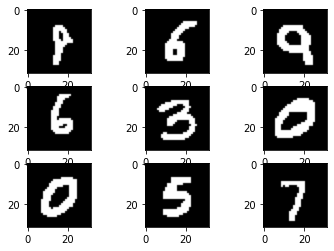

In [0]:
import random
%matplotlib inline

# index = random.randint(0, len(data.x_train))
# image = data.x_train[index].squeeze()

# plt.figure(figsize=(5,5))
# plt.imshow(image, cmap="gray")
# print(y_train[index])
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap="gray")
plt.show()

In [0]:
def get_model(input_shape,classes=10,d_rate=0.2,act='softmax'):
    inputs = layers.Input(shape=input_shape)
    # block 1
    layer = layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same',name='block1_conv1')(inputs)
    layer = layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same',name='block1_conv2')(layer)
    layer = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='block1_pool')(layer)

    # block 2
    layer = layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same',name='block2_conv1')(layer)
    layer = layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same',name='block2_conv2')(layer)
    layer = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),name='block2_pool')(layer)

    # block 3
    layer = layers.Conv2D(filters=256,kernel_size=(3, 3),activation='relu',padding='same',name='block3_conv1')(layer)
    layer = layers.Conv2D(filters=256,kernel_size=(3, 3),activation='relu',padding='same',name='block3_conv2')(layer)
    layer = layers.Conv2D(filters=256,kernel_size=(3, 3),activation='relu',padding='same',name='block3_conv3')(layer)
    layer = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),name='block3_pool')(layer)

    # block 4
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block4_conv1')(layer)
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block4_conv2')(layer)
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block4_conv3')(layer)
    layer = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),name='block4_pool')(layer)

    # block 5
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block5_conv1')(layer)
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block5_conv2')(layer)
    layer = layers.Conv2D(filters=512,kernel_size=(3, 3),activation='relu',padding='same',name='block5_conv3')(layer)
    if layer.shape[1] > 1:
        layer = layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2),name='block5_pool')(layer)

    
    layer = layers.Flatten(name='flatten')(layer)
    layer = layers.Dense(units=4096,activation='relu',name='fc1')(layer)
#     layer = layers.Dropout(0.2)(layer)
    layer = layers.Dense(units=4096,activation='relu',name='fc2')(layer)
#     layer = layers.Dropout(0.2)(layer)
    layer = layers.Dense(units=1000,activation='relu',name='fc3')(layer)
    layer = layers.Dropout(d_rate,name='dropout')(layer)
    layer = layers.Dense(classes,activation=act,use_bias=True,kernel_initializer='glorot_uniform',bias_initializer='zeros',name='predictions')(layer)
    model = models.Model(inputs=inputs, outputs=layer)
    return model

In [0]:
def get_optimiser(opt,learning_rate):
    if opt=='sgd':
        opt_type = keras.optimizers.SGD(lr=learning_rate,decay=1e-6,momentum=0.9,nesterov=True)
    if opt=='adagrad':
        opt_type = keras.optimizers.Adagrad(lr=learning_rate,epsilon=1e-08)
    if opt=='adam':
        opt_type = keras.optimizers.Adam(lr=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-08,amsgrad=False)
    return opt_type

## MNIST

In [0]:
learning_rate = 0.01
dropout_rate = 0.2
act = 'softmax'
opt = 'sgd'
classes = 10
dataset = "mnist"
input_dims = (32,32)
print("**Selecting Dataset", dataset)
print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
print("**Dataset Dimensions:")
print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


**Selecting Dataset mnist
**Coverting  mnist  to 3 channel dims  (32, 32)
**Dataset Dimensions:
**Training Dataset Dims:  (40200, 32, 32, 3) (40200, 10)
**Validation Dataset Dims:  (19800, 32, 32, 3) (19800, 10)
**Test Dataset Dims:  (10000, 32, 32, 3) (10000, 10)


In [0]:
input_shape = x_train.shape[1:]
print("**Creating VGG16 network")
inputs = layers.Input(shape=input_shape)
model = get_model(input_shape,classes,dropout_rate,act)
print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
opt_type = get_optimiser(opt,learning_rate)

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
plot_model(model, to_file='model/vgg16.png')

print(model.summary())

print("**Starting Training..")
start = time.time()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val))
end = time.time()
total_exec_time = end - start
print("**Total Execution time", total_exec_time)

**Creating VGG16 network
**Selecting Optimiser sgd  with Learning rate  0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
________________________________________________

In [0]:
print("Saving Network and weights")
weight_path = 'model/vgg16_wt.h5'
model.save_weights(weight_path)

Saving Network and weights


In [0]:
print("Evaluating network performance on Test Data")
score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Evaluating network performance on Test Data
10000/10000 [==============================] - 1s 106us/step
Test loss: 0.030621020053327085
Test accuracy: 0.9918000102043152


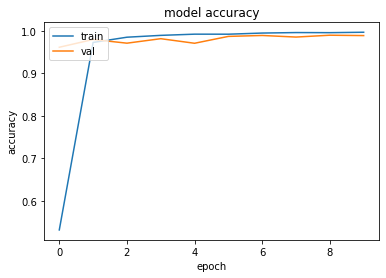

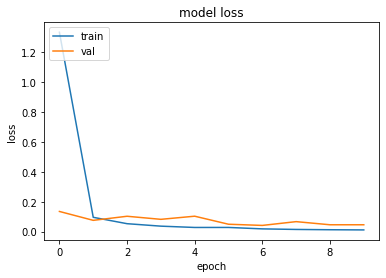

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
predictions = model.predict(x_test, verbose=0)

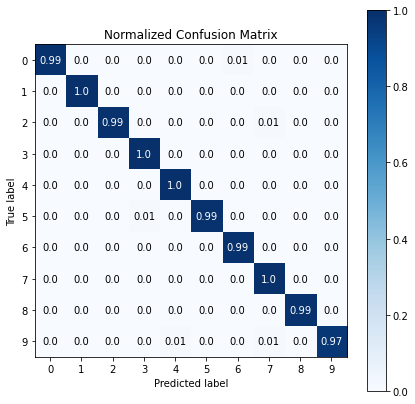

In [0]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), normalize=True,figsize = (7,7))

In [0]:
def test_accuracy():
    err = []
    tru = []
    for i in range(predictions.shape[0]):
        if np.argmax(predictions[i]) == np.argmax(y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

# plt.subplot(330 + 1 + i)
# plt.imshow(x_train[i], cmap="gray")
print("True:          {}".format(np.argmax(y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[1][6:11]], axis=1)))

True:          [7 2 1 0 4]
classified as: [7 2 1 0 4]
Error Cases
True:          [2 1 2 3 8]
classified as: [4 7 7 5 9]


In [0]:
K.clear_session()

## CIFAR10

In [0]:
learning_rate = 0.01
dropout_rate = 0.2
act = 'softmax'
opt = 'sgd'
classes = 10
dataset = "cifar10"
input_dims = (32,32)
print("**Selecting Dataset", dataset)
print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
print("**Dataset Dimensions:")
print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


**Selecting Dataset cifar10
**Coverting  cifar10  to 3 channel dims  (32, 32)
170500096/170498071 [==============================] - 2s 0us/step
**Dataset Dimensions:
**Training Dataset Dims:  (33500, 32, 32, 3) (33500, 10)
**Validation Dataset Dims:  (16500, 32, 32, 3) (16500, 10)
**Test Dataset Dims:  (10000, 32, 32, 3) (10000, 10)


In [0]:
input_shape = x_train.shape[1:]
print("**Creating VGG16 network")
inputs = layers.Input(shape=input_shape)
model = get_model(input_shape,classes,dropout_rate,act)
print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
opt_type = get_optimiser(opt,learning_rate)

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
plot_model(model, to_file='model/vgg16.png')

print(model.summary())

print("**Starting Training..")
start = time.time()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val))
end = time.time()
total_exec_time = end - start
print("**Total Execution time", total_exec_time)

**Creating VGG16 network
**Selecting Optimiser sgd  with Learning rate  0.01
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
________________________________________________

In [0]:
print("Saving Network and weights")
weight_path = 'model/vgg16_wt.h5'
model.save_weights(weight_path)

Saving Network and weights


In [0]:
print("Evaluating network performance on Test Data")
score = model.evaluate(x_test, y_test, verbose=1,batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
predictions = model.predict(x_test, verbose=0)

In [0]:
# from sklearn.metrics import classification_report, confusion_matrix
# confusion_matrix(np.argmax(data.y_test,axis=1),np.argmax(predictions,axis=1))
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1), normalize=True,figsize = (7,7))

In [0]:
def test_accuracy():
    err = []
    tru = []
    for i in range(predictions.shape[0]):
        if np.argmax(predictions[i]) == np.argmax(y_test[i]):
            tru.append(i)
        else:
            err.append(i)
    return tru, err

p = test_accuracy()

# plt.subplot(330 + 1 + i)
# plt.imshow(x_train[i], cmap="gray")
print("True:          {}".format(np.argmax(y_test[p[0][0:5]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[0][0:5]], axis=1)))
print("Error Cases")
print("True:          {}".format(np.argmax(y_test[p[1][6:11]], axis =1)))
print("classified as: {}".format(np.argmax(predictions[p[1][6:11]], axis=1)))

In [0]:
K.clear_session()

## Paramter Evalaution

In [0]:
# performing best optimiser selection on mnist and cifar
for dataset in ['mnist','cifar10']:
    for opt in ['sgd', 'adam', 'adagrad']:
        learning_rate = 0.01
        dropout_rate = 0.2
        act = 'softmax'
        # opt = 'sgd'
        classes = 10
        dataset = "cifar10"
        input_dims = (32,32)
        print("**Selecting Dataset", dataset)
        print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
        x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
        print("**Dataset Dimensions:")
        print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
        print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
        print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


        input_shape = x_train.shape[1:]
        print("**Creating VGG16 network")
        inputs = layers.Input(shape=input_shape)
        model = get_model(input_shape,classes,dropout_rate,act)
        print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
        opt_type = get_optimiser(opt,learning_rate)

        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
        plot_model(model, to_file='model/vgg16.png')

        print(model.summary())

        print("**Starting Training..")
        start = time.time()
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=10,
                            verbose=1,
                            validation_data=(x_val, y_val))
        end = time.time()
        total_exec_time = end - start

        print("Saving Network and weights")
        weight_path = 'model/vgg16_wt.h5'
        model.save_weights(weight_path)
        print("Evaluating network performance on Test Data")
        score = model.evaluate(data.x_test, data.y_test, verbose=1,batch_size=batch_size)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        hist = {}
        hist['model_name'] = 'VGG16'
        hist['dataset'] = dataset
        hist['dropout_rate'] = dropout_rate
        hist['activation'] = act
        hist['lr_rate'] = learning_rate
        hist['epochs'] = epochs
        hist['opt'] = opt
        hist['input_dims'] = data.x_train.shape[1:]
        hist = dict(hist, **history.history)
        hist['test_loss'] = score[0]
        hist['test_accuracy'] = score[1]
        np.save('model.txt',hist)
        result = result.append(hist, ignore_index=True)
        result.to_csv("vgg_n.csv", index=False)
        # K.clear_session()
        # cuda.select_device(0)
        # cuda.close()

In [0]:
result.to_csv("vgg.csv", index=False)

In [0]:
K.clear_session()

In [0]:
# checking performace on diffent learning rates for mnist
for dataset in ['mnist','cifar10']:
    for learning_rate in [0.0001, 0.001, 0.01, 0.1, 0.5, 1]:
        # learning_rate = 0.01
        dropout_rate = 0.2
        act = 'softmax'
        opt = 'sgd'
        classes = 10
        dataset = "cifar10"
        input_dims = (32,32)
        print("**Selecting Dataset", dataset)
        print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
        x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
        print("**Dataset Dimensions:")
        print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
        print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
        print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


        input_shape = x_train.shape[1:]
        print("**Creating VGG16 network")
        inputs = layers.Input(shape=input_shape)
        model = get_model(input_shape,classes,dropout_rate,act)
        print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
        opt_type = get_optimiser(opt,learning_rate)

        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
        plot_model(model, to_file='model/vgg16.png')

        print(model.summary())

        print("**Starting Training..")
        start = time.time()
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=10,
                            verbose=1,
                            validation_data=(x_val, y_val))
        end = time.time()
        total_exec_time = end - start

        print("Saving Network and weights")
        weight_path = 'model/vgg16_wt.h5'
        model.save_weights(weight_path)
        print("Evaluating network performance on Test Data")
        score = model.evaluate(data.x_test, data.y_test, verbose=1,batch_size=batch_size)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        hist = {}
        hist['model_name'] = 'VGG16'
        hist['dataset'] = dataset
        hist['dropout_rate'] = dropout_rate
        hist['activation'] = act
        hist['lr_rate'] = learning_rate
        hist['epochs'] = epochs
        hist['opt'] = opt
        hist['input_dims'] = data.x_train.shape[1:]
        hist = dict(hist, **history.history)
        hist['test_loss'] = score[0]
        hist['test_accuracy'] = score[1]
        np.save('model.txt',hist)
        result = result.append(hist, ignore_index=True)
        result.to_csv("vgg_n.csv", index=False)
        # K.clear_session()
        # cuda.select_device(0)
        # cuda.close()

In [0]:
result.to_csv("vgg.csv", index=False)

In [0]:
K.clear_session()

In [0]:
# checking performace on diffent activation for mnist
for dataset in ['mnist','cifar10']:
    for act in ['softmax','relu', 'tanh', 'elu']:
        learning_rate = 0.01
        dropout_rate = 0.2
        # act = 'softmax'
        opt = 'sgd'
        classes = 10
        dataset = "cifar10"
        input_dims = (32,32)
        print("**Selecting Dataset", dataset)
        print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
        x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
        print("**Dataset Dimensions:")
        print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
        print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
        print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


        input_shape = x_train.shape[1:]
        print("**Creating VGG16 network")
        inputs = layers.Input(shape=input_shape)
        model = get_model(input_shape,classes,dropout_rate,act)
        print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
        opt_type = get_optimiser(opt,learning_rate)

        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
        plot_model(model, to_file='model/vgg16.png')

        print(model.summary())

        print("**Starting Training..")
        start = time.time()
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=10,
                            verbose=1,
                            validation_data=(x_val, y_val))
        end = time.time()
        total_exec_time = end - start

        print("Saving Network and weights")
        weight_path = 'model/vgg16_wt.h5'
        model.save_weights(weight_path)
        print("Evaluating network performance on Test Data")
        score = model.evaluate(data.x_test, data.y_test, verbose=1,batch_size=batch_size)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        hist = {}
        hist['model_name'] = 'VGG16'
        hist['dataset'] = dataset
        hist['dropout_rate'] = dropout_rate
        hist['activation'] = act
        hist['lr_rate'] = learning_rate
        hist['epochs'] = epochs
        hist['opt'] = opt
        hist['input_dims'] = data.x_train.shape[1:]
        hist = dict(hist, **history.history)
        hist['test_loss'] = score[0]
        hist['test_accuracy'] = score[1]
        np.save('model.txt',hist)
        result = result.append(hist, ignore_index=True)
        result.to_csv("vgg_n.csv", index=False)
        # K.clear_session()
        # cuda.select_device(0)
        # cuda.close()

In [0]:
result.to_csv("vgg.csv", index=False)

In [0]:
K.clear_session()

In [0]:
# checking performace on diffent dropout for mnist
for dataset in ['mnist','cifar10']:
    for dropout_rate in [0.1, 0.3, 0.7, 0.9]:
        learning_rate = 0.01
        # dropout_rate = 0.2
        act = 'softmax'
        opt = 'sgd'
        classes = 10
        dataset = "cifar10"
        input_dims = (32,32)
        print("**Selecting Dataset", dataset)
        print("**Coverting ",dataset," to 3 channel dims ",str(input_dims))
        x_train, x_test, x_val, y_train, y_test, y_val = get_dataset(dataset,final_shape=(32,32))
        print("**Dataset Dimensions:")
        print("**Training Dataset Dims: ",x_train.shape,y_train.shape)
        print("**Validation Dataset Dims: ",x_val.shape,y_val.shape)
        print("**Test Dataset Dims: ",x_test.shape,y_test.shape)


        input_shape = x_train.shape[1:]
        print("**Creating VGG16 network")
        inputs = layers.Input(shape=input_shape)
        model = get_model(input_shape,classes,dropout_rate,act)
        print("**Selecting Optimiser", opt," with Learning rate ",learning_rate)
        opt_type = get_optimiser(opt,learning_rate)

        model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt_type,metrics=['accuracy'])
        plot_model(model, to_file='model/vgg16.png')

        print(model.summary())

        print("**Starting Training..")
        start = time.time()
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=10,
                            verbose=1,
                            validation_data=(x_val, y_val))
        end = time.time()
        total_exec_time = end - start

        print("Saving Network and weights")
        weight_path = 'model/vgg16_wt.h5'
        model.save_weights(weight_path)
        print("Evaluating network performance on Test Data")
        score = model.evaluate(data.x_test, data.y_test, verbose=1,batch_size=batch_size)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        hist = {}
        hist['model_name'] = 'VGG16'
        hist['dataset'] = dataset
        hist['dropout_rate'] = dropout_rate
        hist['activation'] = act
        hist['lr_rate'] = learning_rate
        hist['epochs'] = epochs
        hist['opt'] = opt
        hist['input_dims'] = data.x_train.shape[1:]
        hist = dict(hist, **history.history)
        hist['test_loss'] = score[0]
        hist['test_accuracy'] = score[1]
        np.save('model.txt',hist)
        result = result.append(hist, ignore_index=True)
        result.to_csv("vgg_n.csv", index=False)
        # K.clear_session()
        # cuda.select_device(0)
        # cuda.close()

In [0]:
result.to_csv("vgg.csv", index=False)

In [0]:
K.clear_session()